**P2 - Team Rabbit Classifier**

In the current state of the project, we have developed a program that prepares the dataset for training, and is able to be processed by a simple Convolutional Neural Network architecture. As part of our data exploration, we pulled the hare and rabbit photos from our gitlab repository and converted the images from RGB to grayscale. In addition, we normalized the data and then provided padding to the dataset so that all input images would be uniformly sized at (200, 200). In order to process the organized data, we tested several architectures and observed the impact of iteratively modifying several hyperparameters, such as batch size and the quantity of epochs. Currently, the high training accuracy and low validation accuraccy (~0.55) is indicative of the model overfitting on the data. To overcome this, we believe that the current architecture should be extended to include a more gradual decrease in the size of the tensor over more convolutional and deep layers. This will increase the information that can be extracted from each pass and increase the validation accuracy.

Our Planned Next Steps:
- Redesigning and extending our network architecture. In particular, this will involve adding more convolutional and dense layers to reduce our tensor more gradually to reach the final output more effectively, in the hopes of improving our validation accuracy. 
- Hyperparameter fine-tuning to maximize the validation accuracy and provide detailed insights into their impact on the model performance.
- Coduct a detailed theoretical analysis of our model, and relate it to the performance observed in the experimentation process.

In [ ]:
!pip install loguru
!pip install pipetools

# Data Exploration

In [ ]:
!mkdir -p /tmp
!curl https://raw.githubusercontent.com/urmzd/rabbit-classifier/main/resources/data.csv --output /tmp/data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9380  100  9380    0     0   147k      0 --:--:-- --:--:-- --:--:--  147k


In [ ]:
import pandas as pd
import requests
import re
import pathlib
from loguru import logger

DATA_PATH="/tmp/data.csv"
IMAGE_PATH="/tmp/images"

def get_data():
  df = pd.read_csv(DATA_PATH, usecols=range(2))
  return df

def download_image(link: str) -> pathlib.Path:
  # view  : https://regex101.com/r/3bhDMM/1
  # delete: https://regex101.com/delete/N5sItwbrPF73ZllTnRDltxZ1
  file_name_regex = re.compile(r".*\/(.*(\.(jpeg|jpg|png))?)\??.*", flags=re.IGNORECASE)
  regex_matches = file_name_regex.match(link)

  if not regex_matches:
    raise Exception(f"Failed to match file_name for link {link}")

  if len(regex_matches.groups()) < 3:
    file_name = regex_matches.group(1) + ".png"
  else:
    file_name = regex_matches.group(1)

  content_path = pathlib.Path(IMAGE_PATH)
  content_path.mkdir(parents=True, exist_ok=True)

  file_path = content_path / file_name

  if file_path.exists():
    return file_path

  image_request_headers={
      'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
  }

  image = requests.get(link, headers=image_request_headers)

  with open(file_path, "wb") as handle:
    handle.write(image.content)

  return file_path

df = get_data()
df.head()

,label,link
0,rabbit,https://upload.wikimedia.org/wikipedia/commons...
1,rabbit,https://upload.wikimedia.org/wikipedia/commons...
2,rabbit,https://www.massaudubon.org/var/ezdemo_site/st...
3,rabbit,https://www.welcomewildlife.com/wp-content/upl...
4,rabbit,https://i.natgeofe.com/k/58df97a7-5c47-44b8-97...


In [ ]:
import cv2
from typing import NewType, Tuple, List
import numpy as np

Image = NewType('Image', np.array)
Label = NewType('Label', str)
ImageLabelPair = Tuple[Image, Label]

def get_image(file_path: pathlib.Path, show=False) -> Image:
  image = cv2.imread(str(file_path))

  if show:
    plt.imshow(image)
    
  return Image(image)

RawX = NewType('RawX', List[Image])
RawY = NewType('RawY', np.ndarray)

def get_x_y(raw_data: pd.DataFrame) -> Tuple[RawX, RawY]:
  y = raw_data.iloc[:, 0].to_numpy()
  y = y.reshape(-1, 1)

  x_links = raw_data.iloc[:, 1].tolist()
  x_paths = [download_image(link) for link in x_links]
  x = [get_image(path) for path in x_paths]

  return RawX(x), RawY(y)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import albumentations as A
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from pipetools import pipe, foreach

random.seed(42)

DESIRED_HEIGHT = 200
DESIRED_WIDTH = 200
SCALE_HEIGHT = False

def get_scaled_dimensions(dim1: int, dim2:int, target_dim: int, reverse=False):
    aspect_ratio = dim1 / dim2
    scale_dim_by = dim2 / target_dim
    scaled_dim2 = round(dim2 / scale_dim_by)
    scaled_dim1 = round(dim1 / scale_dim_by * aspect_ratio)

    scaled_dims = (scaled_dim1, scaled_dim2)

    if reverse:
      return scaled_dims[::-1]

    return scaled_dims
    


def get_x_encoder():

  def change_image_to_greyscale(img: Image) -> Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  def normalize_image(img: Image) -> Image:
    return cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

  def resize_image(img: Image) -> Image:
    height, width, _ = img.shape
    scaled_dims = get_scaled_dimensions(width, height, target_dim=DESIRED_WIDTH) if SCALE_HEIGHT else get_scaled_dimensions(height, width, target_dim=DESIRED_HEIGHT, reverse=True)
    return cv2.resize(img, scaled_dims)

  def pad_image(img: Image) -> Image:
    height, width = img.shape
    bottom = 0
    top = 0
    left = 0
    right = 0
    if SCALE_HEIGHT:
      width_padding_needed = max(DESIRED_WIDTH - width,0)
      width_padding_per_side = width_padding_needed // 2
      
      left = width_padding_per_side
      right = width_padding_per_side

      if width_padding_needed % 2 == 1:
        right += 1
    else:
      height_padding_needed = max(DESIRED_HEIGHT - height,0)
      height_padding_per_side = height_padding_needed // 2

      top = height_padding_per_side
      bottom = height_padding_per_side

      if height_padding_needed % 2 == 1:
        top += 1

    padded_image = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
    # return img
    return padded_image

  def crop_image(img: Image):
    height, width = img.shape

    h_low = 0
    h_high = DESIRED_HEIGHT
    w_low = 0
    w_high = DESIRED_WIDTH

    if SCALE_HEIGHT:
      difference = DESIRED_WIDTH - width
      crops = difference // 2
      w_low = 0 - crops
      w_high = width + crops

      if difference % 2 == 1:
        w_high += 1
    else:
      difference = DESIRED_HEIGHT - height
      crops = difference // 2
      h_low = 0 - crops
      h_high = height + crops

      if difference % 2 == 1:
        h_high += 1

    # return img

    return img[h_low:h_high, w_low:w_high]



  return pipe | resize_image | change_image_to_greyscale | normalize_image | pad_image | crop_image

def get_x_y_preprocessors(x: RawX, y: RawY):  
  y_encoder = OneHotEncoder(sparse=False).fit(y)
  x_encoder = get_x_encoder()

  return x_encoder, y_encoder

def get_processed_x_y(x: RawX, y: RawY):

  x_encoder, y_encoder = get_x_y_preprocessors(x, y)

  x_encoded = x > foreach(x_encoder) | list | np.array 

  y_encoded: np.ndarray = y_encoder.transform(y)

  return x_encoded, y_encoded

In [ ]:
data = get_data()
x, y = get_x_y(data)

2022-03-16 17:21:46.389 | INFO     | __main__:<module>:8 - DIMENSIONS: (200, 200) 
2022-03-16 17:21:46.393 | INFO     | __main__:<module>:9 - MIN:  0.0
2022-03-16 17:21:46.396 | INFO     | __main__:<module>:10 - MAX:  1.0
2022-03-16 17:21:46.424 | INFO     | __main__:<module>:8 - DIMENSIONS: (200, 200) 
2022-03-16 17:21:46.425 | INFO     | __main__:<module>:9 - MIN:  0.0
2022-03-16 17:21:46.427 | INFO     | __main__:<module>:10 - MAX:  1.0
2022-03-16 17:21:46.435 | INFO     | __main__:<module>:8 - DIMENSIONS: (200, 200) 
2022-03-16 17:21:46.439 | INFO     | __main__:<module>:9 - MIN:  0.0
2022-03-16 17:21:46.441 | INFO     | __main__:<module>:10 - MAX:  0.9999999403953552
2022-03-16 17:21:46.444 | INFO     | __main__:<module>:8 - DIMENSIONS: (200, 200) 
2022-03-16 17:21:46.446 | INFO     | __main__:<module>:9 - MIN:  0.0
2022-03-16 17:21:46.448 | INFO     | __main__:<module>:10 - MAX:  1.0
2022-03-16 17:21:46.452 | INFO     | __main__:<module>:8 - DIMENSIONS: (200, 200) 
2022-03-16 17:

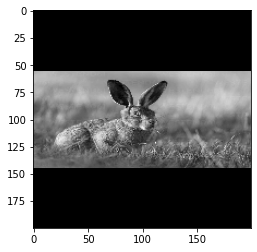

In [ ]:
# raw_image = x[-1]
# image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
# image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# logger.info(image.shape)
# logger.info(image.dtype)
dataset = get_processed_x_y(x, y)
for image in dataset[0]:
  logger.info(f"DIMENSIONS: {image.shape} ")
  logger.info(f"MIN:  {np.min(image)}")
  logger.info(f"MAX:  {np.max(image)}")
  plt.imshow(image, cmap="gray")

# BASIC ARCHITECTURE EXPERIMENTS + OVERFITTING

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib as plt

In [ ]:
x_t = dataset[0]
y_t = dataset[1]

In [ ]:
dataset[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
shapes = []
for i in range(len(x)):

 shapes.append(x_t[i].shape)

print(max(shapes))
print(shapes)

(200, 200)
[(200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200

**Basic Test of Simple Architecture, 10 epoch training with 32 batch size**

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(200,200,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation = "sigmoid"))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 313632)            0         
                                                                 
 dense_8 (Dense)             (None, 2)                 627266    
                                                                 
Total params: 627,586
Trainable params: 627,586
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.asarray(x_t), np.asarray(y_t), test_size = 0.2, random_state = 42)

In [ ]:
np.random.seed(42)

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,epochs = 10,batch_size=32, validation_data=(x_test,y_test))

Epoch 1/10
3/3 [==============================] - 2s 624ms/step - loss: 1.0147 - accuracy: 0.7500 - val_loss: 2.3271 - val_accuracy: 0.4706
Epoch 2/10
3/3 [==============================] - 2s 598ms/step - loss: 0.5091 - accuracy: 0.8382 - val_loss: 1.4425 - val_accuracy: 0.5294
Epoch 3/10
3/3 [==============================] - 2s 626ms/step - loss: 0.5329 - accuracy: 0.7794 - val_loss: 1.3835 - val_accuracy: 0.4706
Epoch 4/10
3/3 [==============================] - 2s 690ms/step - loss: 0.1470 - accuracy: 0.9559 - val_loss: 1.8966 - val_accuracy: 0.4706
Epoch 5/10
3/3 [==============================] - 2s 467ms/step - loss: 0.3615 - accuracy: 0.7941 - val_loss: 1.6948 - val_accuracy: 0.4118
Epoch 6/10
3/3 [==============================] - 2s 594ms/step - loss: 0.1528 - accuracy: 0.9265 - val_loss: 1.4356 - val_accuracy: 0.4706
Epoch 7/10
3/3 [==============================] - 2s 649ms/step - loss: 0.1383 - accuracy: 0.9706 - val_loss: 1.3076 - val_accuracy: 0.5294
Epoch 8/10
3/3 [====

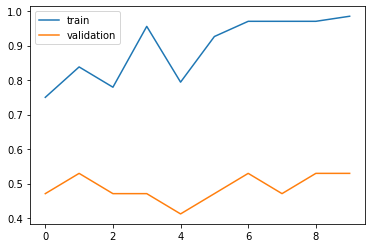

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

**Overfit via Single Batch, 100 Epochs**

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(200,200,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation = "sigmoid"))
model.summary()
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
history = model.fit(x_train,y_train,batch_size=1,epochs = 100,validation_data=(x_test,y_test))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 313632)            0         
                                                                 
 dense_9 (Dense)             (None, 2)                 627266    
                                                                 
Total params: 627,586
Trainable params: 627,586
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
68/68 [==============================] - 3s 39ms/step - loss: 4.6091 - accuracy: 0.4853 - val_loss: 0

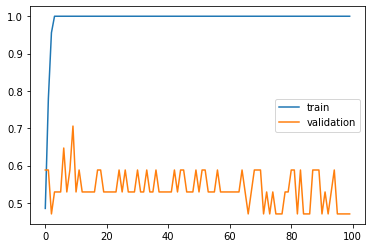

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

**Experimenting with 32 batch size, 50 epochs**

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(200,200,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation = "sigmoid"))
model.summary()
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
history = model.fit(x_train,y_train,batch_size=32,epochs = 50,validation_data=(x_test,y_test))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 313632)            0         
                                                                 
 dense_7 (Dense)             (None, 2)                 627266    
                                                                 
Total params: 627,586
Trainable params: 627,586
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
3/3 [==============================] - 2s 481ms/step - loss: 9.3102 - accuracy: 0.3824 - val_loss: 2.8

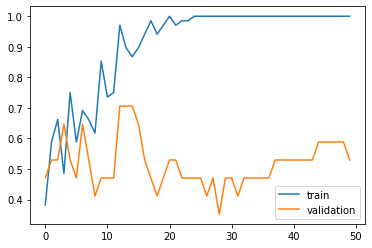

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

**Basic Arch with 16 Batch Size and 25 Epochs**

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(200,200,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation = "sigmoid"))
model.summary()
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
history = model.fit(x_train,y_train,batch_size=16,epochs = 25,validation_data=(x_test,y_test))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 313632)            0         
                                                                 
 dense_12 (Dense)            (None, 2)                 627266    
                                                                 
Total params: 627,586
Trainable params: 627,586
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
5/5 [==============================] - 3s 318ms/step - loss: 2.2335 - accuracy: 0.6471 - val_loss: 5.4

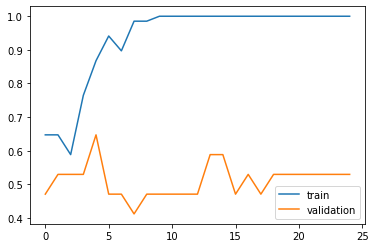

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()